In [1]:
from pathlib import Path
import numpy as np
import os,sys
import pandas as pd
import os
import skseq
from skseq.sequences.extended_feature import ExtendedFeatures
import utils
import skseq.sequences.structured_perceptron as spc

currentdir = Path.cwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 



# Structured Perceptron

In [2]:
X_tr, y_tr = utils.gen_set("./data/train_data_ner.csv")
X_test, y_test = utils.gen_set("./data/test_data_ner.csv")
X_tiny, y_tiny = utils.gen_set("./data/tiny_test.csv")

In [3]:
word_dict, tag_dict, rev_dict = utils.dictionary(X_tr, y_tr)

In [4]:
seq = utils.get_seq(word_dict, tag_dict, X_tr, y_tr)

## Base Model

In [5]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(seq)

In [6]:
feature_mapper.build_features()

In [7]:

sp = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper)
sp.num_epochs = 5
sp.load_model(dir="./fitted_models/sp_base_")

### Train

In [8]:
y_hats = utils.get_predictions(sp, X_tr)

In [9]:
y_tr_ls = np.array([tag_dict[t] for t in np.concatenate(y_tr)])

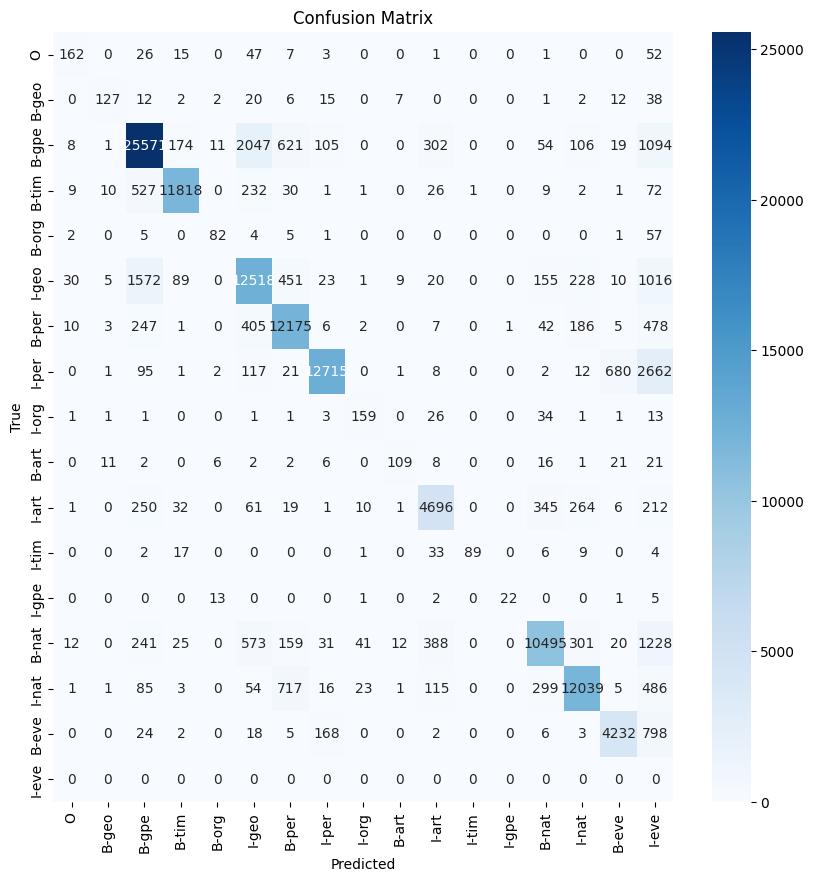

{'accuracy with O': 0.9684081697831473,
 'accuracy': 0.8310862237686202,
 'f1_score': 0.9681914545870688}

In [10]:
utils.evaluate(y_tr_ls, y_hats, rev_dict)

### Test

In [11]:
y_hats = utils.get_predictions(sp, X_test)

In [12]:
y_test_ls = np.array([tag_dict[t] for t in np.concatenate(y_test)])

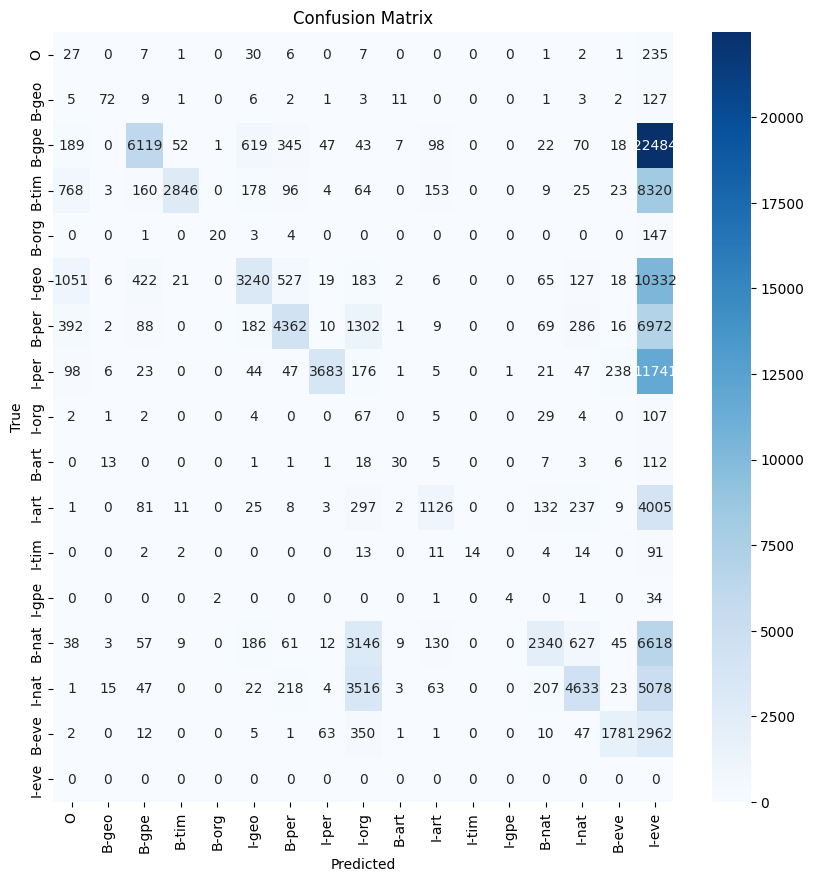

{'accuracy with O': 0.8772335877133269,
 'accuracy': 0.2367877223491613,
 'f1_score': 0.8531773343020015}

In [13]:
utils.evaluate(y_test_ls, y_hats, rev_dict)

### Tiny Test

In [14]:
y_hats = utils.get_predictions(sp, X_tiny)

In [15]:
y_tiny_ls = np.array([tag_dict[t] for t in np.concatenate(y_tiny)])

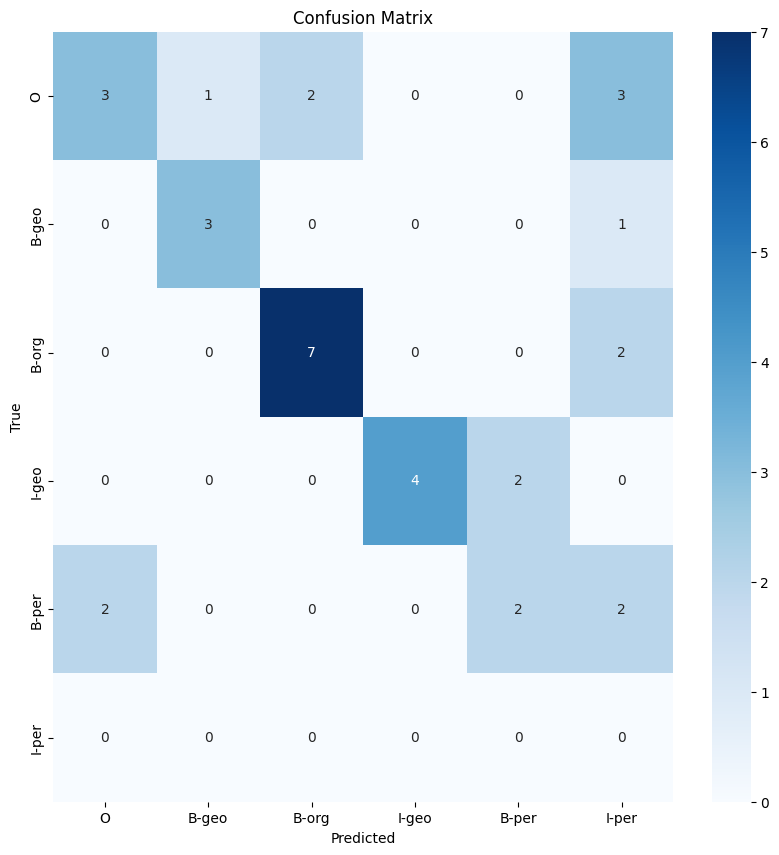

{'accuracy with O': 0.8972602739726028,
 'accuracy': 0.5588235294117647,
 'f1_score': 0.8848977663809974}

In [16]:
utils.evaluate(y_tiny_ls, y_hats, rev_dict)

In [21]:
utils.print_tiny_test(X_tiny, y_hats, rev_dict)

=========TINY TEST=========
The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 
The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 
Jack/B-per London/B-geo went/O to/O Parris/O ./O 
Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 
Bill/B-per gates/O and/O Steve/B-per jobs/O never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 
Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 
The/O president/O of/O U.S.A/O thought/O they/O could/O win/O the/O war/O ./O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo thought/O they/O could/O win/O the/O war/O ./O 
The/O king/O of/O Saudi/B-per Arabia/I-per wanted/O total/O control/O ./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia/I-per ./O 
Apple/O is/O a/O great/O company/O

## Extended Features

In [22]:
feature_mapper_extra = ExtendedFeatures(seq)
feature_mapper_extra.build_features()

In [23]:
sp = spc.StructuredPerceptron(word_dict, tag_dict, feature_mapper_extra)
sp.num_epochs = 5
sp.load_model(dir="./fitted_models/sp_ext_")

### Train

In [24]:
y_hats = utils.get_predictions(sp, X_tr)

In [ ]:
y_tr_ls = np.array([tag_dict[t] for t in np.concatenate(y_tr)])

{'accuracy with O': 0.963219530448399,
 'accuracy': 0.8315910467699095,
 'f1_score': 0.9639048305699943}

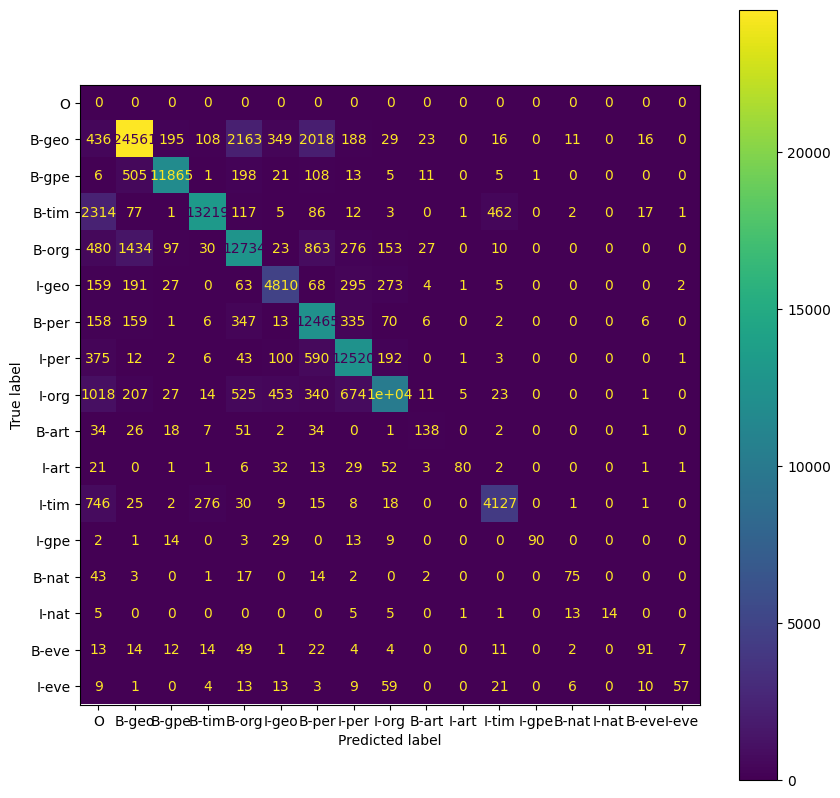

In [ ]:
utils.evaluate(y_tr_ls, y_hats, rev_dict)

### Test

In [ ]:
y_hats = utils.get_predictions(sp, X_test)

In [ ]:
y_test_ls = np.array([tag_dict[t] for t in np.concatenate(y_test)])

{'accuracy with O': 0.8992929908160462,
 'accuracy': 0.42365849664282984,
 'f1_score': 0.9009099455763558}

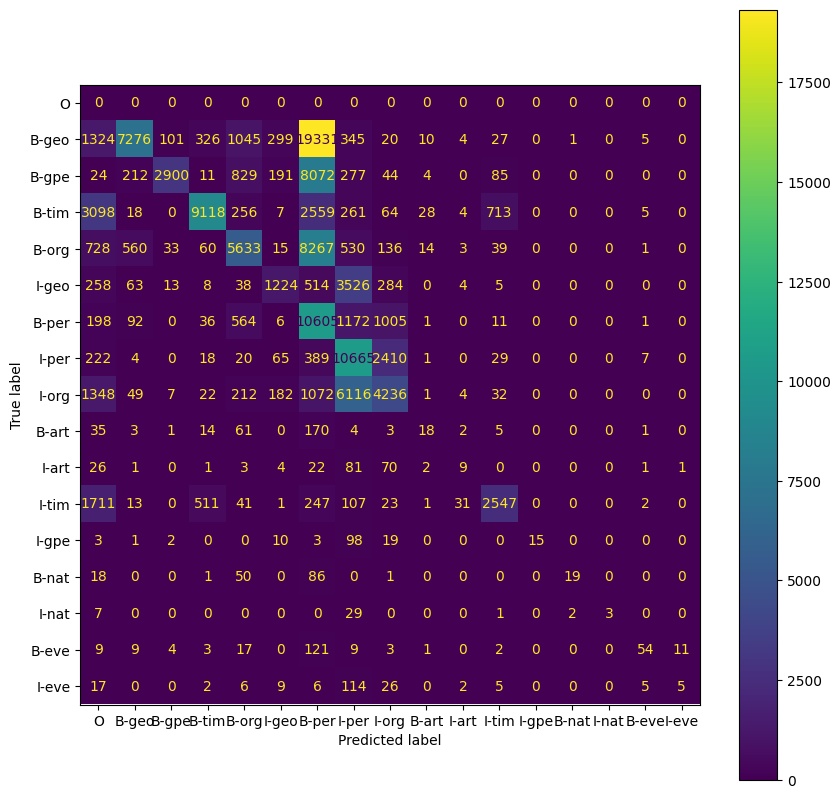

In [ ]:
utils.evaluate(y_test_ls, y_hats, rev_dict)

### Tiny Test

In [ ]:
y_hats = utils.get_predictions(sp, X_tiny)

In [ ]:
y_tiny_ls = np.array([tag_dict[t] for t in np.concatenate(y_tiny)])

{'accuracy with O': 0.958904109589041,
 'accuracy': 0.8235294117647058,
 'f1_score': 0.952800339435083}

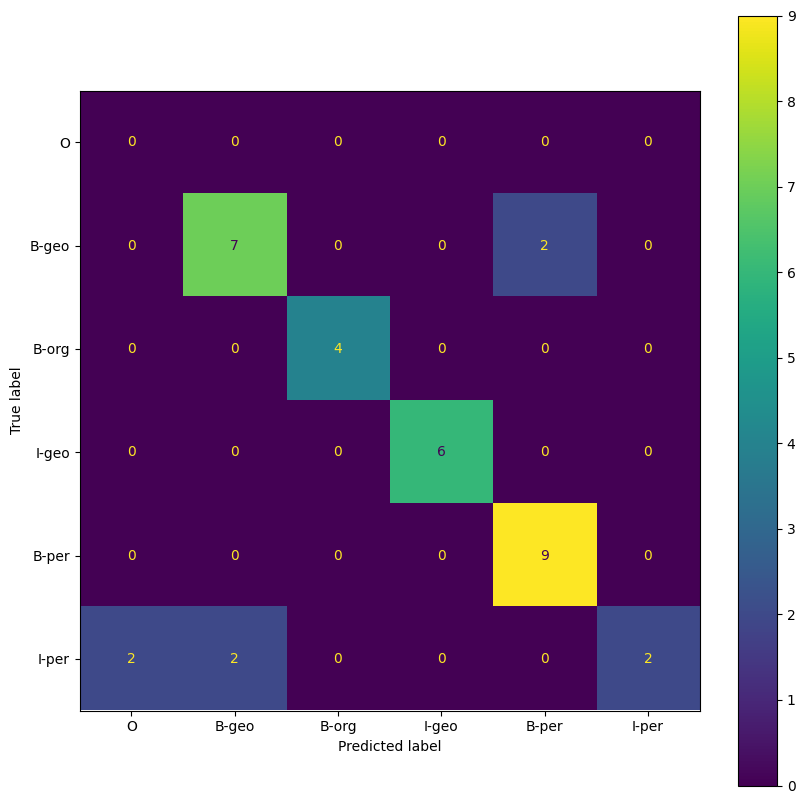

In [ ]:
utils.evaluate(y_tiny_ls, y_hats, rev_dict)

In [ ]:
utils.print_tiny_test(X_tiny, y_hats, rev_dict)

# Deep Learning

### BERT fine-tuning

In [ ]:
!pip install torcheval peft

In [1]:
import torcheval.metrics
from utils import parse_dataset, Params, NERDataset, get_evaluation_pred_and_label, gen_set, evaluate_integers, print_tiny_test

In [ ]:
base_folder = './data/'
training = 'train_data_ner.csv'
test = 'test_data_ner.csv'
tiny = 'tiny_test.csv'

full_train, full_train_label = parse_dataset(base_folder + training)
len_train = int(len(full_train) * 0.9)

train_sent, train_label = full_train[:len_train], full_train_label[:len_train]
valid_sent, valid_label = full_train[len_train + 1:], full_train_label[len_train + 1:]

test_sent, test_label = parse_dataset(base_folder + test)
tiny_sent, tiny_label = parse_dataset(base_folder + tiny)

In [ ]:
organized_list = []
for inner_list in train_label + test_label + tiny_label:
    organized_list.extend(inner_list)
set(organized_list)

In [ ]:
PARAMS = {
    'batch_size': 64,
    'epochs': 10,
    'lr': 3e-5,
    'shuffle': False,
    'weight_decay': 1e-4,
    'embeddings_dim': 1024,
}

params = Params(PARAMS)

label2id = {
    'B-art': 0,
    'B-eve': 1,
    'B-geo': 2,
    'B-gpe': 3,
    'B-nat': 4,
    'B-org': 5,
    'B-per': 6,
    'B-tim': 7,
    'I-art': 8,
    'I-eve': 9,
    'I-geo': 10,
    'I-gpe': 11,
    'I-nat': 12,
    'I-org': 13,
    'I-per': 14,
    'I-tim': 15,
    'O': 16
}

In [ ]:
from tqdm import tqdm
import torch
import torch.utils.data as data


# Create the dataset object
train_dataset = NERDataset(train_sent, train_label)
valid_dataset = NERDataset(valid_sent, valid_label)
test_dataset = NERDataset(test_sent, test_label)
tiny_dataset = NERDataset(tiny_sent, tiny_label)

def collate_fn(list_items):
     x = []
     y = []
     for x_, y_ in list_items:
         x.append(x_)
         y.append(y_)
     return x, y

train_loader = data.DataLoader(train_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
valid_loader = data.DataLoader(valid_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
tiny_loader = data.DataLoader(tiny_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)

In [ ]:
from collections import defaultdict

label_count = defaultdict(lambda: 0)
for l in train_label:
  for ll in l:
    label_count[label2id[ll]] += 1

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from peft import get_peft_model, LoraConfig, TaskType
import torch
from torch.optim import AdamW
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label2id.keys()), ignore_mismatched_sizes=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=params.lr)

weights = torch.ones(len(label2id))
loss_fn = torch.nn.CrossEntropyLoss()
f1_func = torcheval.metrics.functional.multiclass_f1_score
acc_func = torcheval.metrics.functional.multiclass_accuracy

history = {}

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

best_model_path = './fitted_models/bert_base_uncased.pt'
model.load_state_dict(torch.load(best_model_path))
model.to(device)

In [ ]:
def get_evaluation_pred_and_label(loader):

  # Validation loop
  model.eval()  # Set the model to evaluation mode
  val_loss = 0.0
  val_acc = 0.0
  val_f1 = 0.0
  tokens = 0
  all_true_labels = []
  all_pred_labels = []

  with torch.no_grad():  # Disable gradient calculation for validation
      for batch_idx, (val_sentences, val_target) in tqdm(enumerate(loader)):
          val_sentences_splited_into_words = [sentence.split(" ") for sentence in val_sentences]
          val_tokens = tokenizer.batch_encode_plus(val_sentences_splited_into_words, padding=True, return_tensors='pt', truncation=True, is_split_into_words=True)
          val_tokens = val_tokens.to(device)
          val_outputs = model(**val_tokens)

          val_loss_batch = 0.0
          val_acc_batch = 0.0
          val_f1_batch = 0.0
          for bb in range(val_outputs.logits.shape[0]):
              ob = torch.argmax(val_outputs.logits[bb], dim=1)
              words_ids = torch.tensor([x for x in val_tokens.word_ids(bb) if x is not None])
              predicted_class = ob[words_ids].to(device)
              real_class = val_target[bb].to(device)[words_ids]

              first_token_indices = []
              current_word_id = None
              for idx, word_id in enumerate(words_ids):
                  if word_id != current_word_id:
                      first_token_indices.append(idx)
                      current_word_id = word_id

              first_token_indices_tensor = torch.tensor(first_token_indices, device=device)

              predicted_class_word = predicted_class[first_token_indices_tensor]
              real_class_word = real_class[first_token_indices_tensor]

              all_true_labels.extend(real_class_word.cpu().numpy())
              all_pred_labels.extend(predicted_class_word.cpu().numpy())

              val_acc_batch += acc_func(predicted_class_word, real_class_word)
              val_f1_batch += f1_func(predicted_class_word, real_class_word)
              tokens += 1

          val_acc += val_acc_batch.item()
          val_f1 += val_f1_batch.item()

  # Filter out 'O' labels
  all_true_labels = torch.tensor(all_true_labels)
  all_pred_labels = torch.tensor(all_pred_labels)
  o_label_id = label2id['O']
  filtered_true_labels = torch.tensor([true for true in all_true_labels if true != o_label_id])
  filtered_pred_labels = torch.tensor([pred for true, pred in zip(all_true_labels, all_pred_labels) if true != o_label_id])

  return all_pred_labels.numpy(), all_true_labels.numpy()

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(train_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(test_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(tiny_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
X_tiny, y_tiny = gen_set(base_folder + tiny)
print_tiny_test(X_tiny, all_pred_labels, id2label)

### BERT + LoRA fine-tuning

In [ ]:
import torcheval.metrics
from utils import parse_dataset, Params, NERDataset, get_evaluation_pred_and_label, gen_set, evaluate_integers, print_tiny_test

In [ ]:
base_folder = './data/'
training = 'train_data_ner.csv'
test = 'test_data_ner.csv'
tiny = 'tiny_test.csv'

full_train, full_train_label = parse_dataset(base_folder + training)
len_train = int(len(full_train) * 0.9)

train_sent, train_label = full_train[:len_train], full_train_label[:len_train]
valid_sent, valid_label = full_train[len_train + 1:], full_train_label[len_train + 1:]

test_sent, test_label = parse_dataset(base_folder + test)
tiny_sent, tiny_label = parse_dataset(base_folder + tiny)

In [ ]:
organized_list = []
for inner_list in train_label + test_label + tiny_label:
    organized_list.extend(inner_list)
set(organized_list)

In [ ]:
PARAMS = {
    'batch_size': 64,
    'epochs': 10,
    'lr': 3e-5,
    'shuffle': False,
    'weight_decay': 1e-4,
    'embeddings_dim': 1024,
}

params = Params(PARAMS)

label2id = {
    'B-art': 0,
    'B-eve': 1,
    'B-geo': 2,
    'B-gpe': 3,
    'B-nat': 4,
    'B-org': 5,
    'B-per': 6,
    'B-tim': 7,
    'I-art': 8,
    'I-eve': 9,
    'I-geo': 10,
    'I-gpe': 11,
    'I-nat': 12,
    'I-org': 13,
    'I-per': 14,
    'I-tim': 15,
    'O': 16
}

In [ ]:
from tqdm import tqdm
import torch
import torch.utils.data as data


# Create the dataset object
train_dataset = NERDataset(train_sent, train_label)
valid_dataset = NERDataset(valid_sent, valid_label)
test_dataset = NERDataset(test_sent, test_label)
tiny_dataset = NERDataset(tiny_sent, tiny_label)

def collate_fn(list_items):
     x = []
     y = []
     for x_, y_ in list_items:
         x.append(x_)
         y.append(y_)
     return x, y

train_loader = data.DataLoader(train_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
valid_loader = data.DataLoader(valid_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)
tiny_loader = data.DataLoader(tiny_dataset, batch_size=params.batch_size, shuffle=params.shuffle, collate_fn=collate_fn)

In [ ]:
from collections import defaultdict

label_count = defaultdict(lambda: 0)
for l in train_label:
  for ll in l:
    label_count[label2id[ll]] += 1

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from peft import get_peft_model, LoraConfig, TaskType
import torch
from torch.optim import AdamW
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label2id.keys()), ignore_mismatched_sizes=True)

lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

model = get_peft_model(model, lora_config)

optimizer = torch.optim.AdamW(model.parameters(), lr=params.lr)

weights = torch.ones(len(label2id))
loss_fn = torch.nn.CrossEntropyLoss()
f1_func = torcheval.metrics.functional.multiclass_f1_score
acc_func = torcheval.metrics.functional.multiclass_accuracy

history = {}

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

best_model_path = './fitted_models/bert_base_uncased_lora.pt'
model.load_state_dict(torch.load(best_model_path))
model.to(device)

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(train_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(test_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
all_pred_labels, all_true_labels = get_evaluation_pred_and_label(tiny_loader)
id2label = {v: k for k, v in label2id.items()}
evaluate_integers(all_true_labels, all_pred_labels, label2id, id2label)

In [ ]:
X_tiny, y_tiny = gen_set(base_folder + tiny)
print_tiny_test(X_tiny, all_pred_labels, id2label)